# Wind Turbine Detection

# Data Description

The dataset was taken from: https://www.kaggle.com/datasets/saurabhshahane/wind-turbine-obj-detection

The dataset contains a set of 1285 overhead images of wind turbines with corresponding YOLO formatted bounding boxes for object detection. These labels contain the class, x and y coordinates and the height and width of the bounding boxes for each wind turbine in the corresponding image.

# Importing necessary libraries & loading data

In [1]:
! pip install albumentations==0.4.6

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 548.0 kB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65174 sha256=4923f97db4be08ddae7a0903a6be2801b4390c79664547446d4fc06360635164
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.1.0
    Uninstalling albumentations-1.1.0:
      Successfully uninstalled albumentations-1.1.0


In [2]:
! pip install effdet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 501.2 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 1.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.5/431.5 kB 2.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.6/106.6 kB 4.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144575 sha256=aa28ae717e150b9c888d36226333c10063328d2d1335059fc3626168861ad3cb
  Stored in directory: /root/.cache/pip/wheels/8b/8d/53/2af8772d9aec614e3fc65e53d4a993ad73c61daa8bbd85a873
  Created wheel for pycocotools: filename=pycocotools-2.0.4-cp37-cp37m-linux_x86_64.whl size=370088 sha

In [3]:
! pip install ensemble-boxes

In [5]:
import os
from tqdm.autonotebook import tqdm, trange
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.image import imread
import copy
import time
from torch.utils.data import Dataset, DataLoader
import random
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
import albumentations.augmentations.functional as F
from pathlib import Path
import PIL
from effdet.config.model_config import efficientdet_model_param_dict
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
from effdet.efficientdet import HeadNet
from effdet.config.model_config import efficientdet_model_param_dict
from ensemble_boxes import ensemble_boxes_wbf
import warnings
from datetime import datetime
from glob import glob

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  


So the pipeline will contain the following steps: resize all images and bounding boxes to a 256x256 size for model training --> predict bounding boxes on unseen data with 256x256 size during inference --> resize predicted images with bounding boxes to the size of original images.

# Data Preprocessing

In [6]:
seed = 7788
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)

# splitting the dataset into train, validation and test parts
images_dir = '../input/wind-turbine-obj-detection/images/images'
boxes_dir = '../input/wind-turbine-obj-detection/labels/labels'
images_filenames = [filename[:-4]+'.jpg' for filename in list(os.listdir(boxes_dir)) if filename[:-4]+'.jpg' in list(os.listdir(images_dir))]
print('Total number of images in the dataset: {}'.format(len(images_filenames)))


random.shuffle(images_filenames)

test_size = 10
train_val_size = len(images_filenames) - test_size
indexes = list(range(train_val_size))
val_part = 0.2
split = int(np.floor(train_val_size * val_part))

train_images_filenames = images_filenames[split:train_val_size]
val_images_filenames = images_filenames[:split]
test_images_filenames = images_filenames[-test_size:]

print('Splitted the dataset into 3 parts: {} train images, {} validation images, {} test images'.format(
    len(train_images_filenames), len(val_images_filenames), len(test_images_filenames)))

Total number of images in the dataset: 1285
Splitted the dataset into 3 parts: 1020 train images, 255 validation images, 10 test images


In [7]:
# function for converting bounding boxes from yolo format to pascal voc format
def yolo_to_voc(yolo_box, image_width, image_height):
    x_c, y_c, w, h = yolo_box
    x_tl = x_c - w / 2
    y_tl = y_c - h / 2
    x_tl *= image_width
    y_tl *= image_height
    w *= image_width
    h *= image_height
    x_br = x_tl + w
    y_br = y_tl + h
    voc_box = np.array([x_tl, y_tl, x_br, y_br], dtype=np.int64)
    voc_box = list(voc_box)
    return voc_box

In [8]:
# function for converting bounding boxes from yolo format to format required by Efficientdet architecture
def convert_to_effdet(box, image_width, image_height, format):
    if format == 'yolo':
        voc_box = yolo_to_voc(box, image_width, image_height)
    elif format == 'pascal_voc':
        voc_box = box
    effdet_order = [1, 0, 3, 2]
    effdet_box = [int(voc_box[i]) for i in effdet_order]
    return effdet_box

In [9]:
# function for visualization of bounding boxes
def visualize_box(image, box, color=(255, 0, 0), thickness=2):
    x_min, x_max, y_min, y_max = int(box[1]), int(box[3]), int(box[0]), int(box[2])
    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    return image

In [10]:
# function for visualization of images with ground truth boxes and predictions
def show_images(images_filenames, images_dir, boxes_dir):
    cols = 2
    rows = len(images_filenames)
    figure, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 50))
    for i, image_filename in enumerate(images_filenames):
        image = cv2.imread(os.path.join(images_dir, image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_width, image_height = image.shape[0], image.shape[1]
        axes[i, 0].imshow(image)
        axes[i, 0].set_title('Image')
        axes[i, 0].set_axis_off()

        boxes = np.loadtxt(os.path.join(boxes_dir, image_filename[:-4]+'.txt'), delimiter=' ')
        if boxes.ndim < 2:
            boxes = boxes[np.newaxis, :]
        boxes = boxes[:, 1:]
        converted_boxes = [convert_to_effdet(box, image_width, image_height, format='yolo') for box in boxes]
        for box in converted_boxes:
            visualize_box(image, box)
        axes[i, 1].imshow(image)
        axes[i, 1].set_title('Ground truth boxes')
        axes[i, 1].set_axis_off()
    plt.tight_layout()
    plt.show()

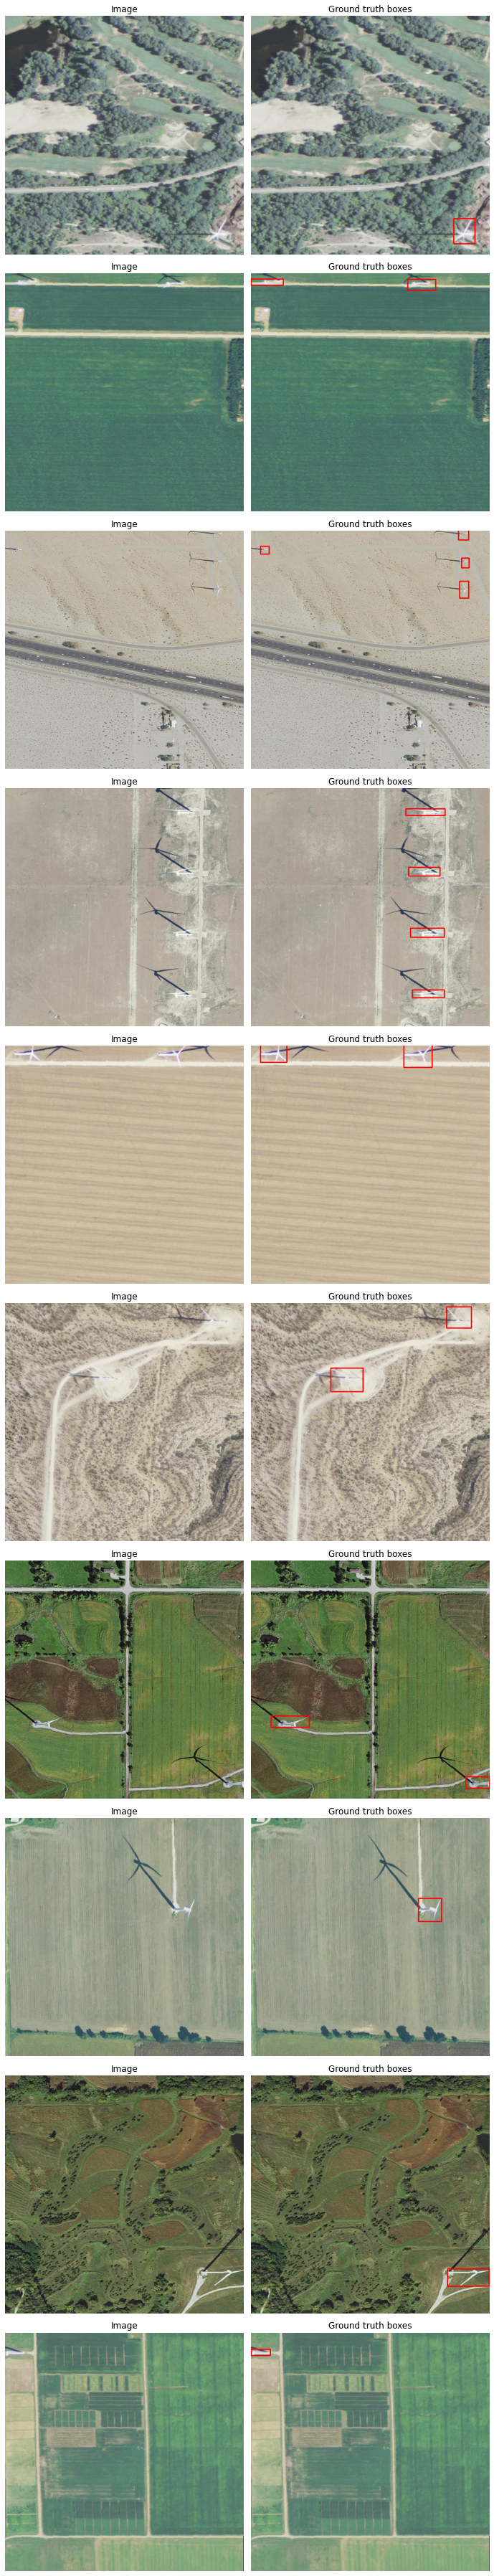

In [11]:
show_images(test_images_filenames, images_dir, boxes_dir)

In [ ]:
class Wind_Turbines_Dataset(Dataset):
    def __init__(self, images_filenames, images_dir, boxes_dir, transform=None):
        self.images_filenames = images_filenames
        self.images_dir = images_dir
        self.boxes_dir = boxes_dir
        self.transform = transform

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, index):
        image_filename = self.images_filenames[index]
        image = cv2.imread(os.path.join(images_dir, image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_height, image_width = image.shape[0], image.shape[1]
        boxes = np.loadtxt(os.path.join(boxes_dir, image_filename[:-4]+'.txt'), delimiter=' ')
        if boxes.ndim < 2:
            boxes = boxes[np.newaxis, :]
        boxes = boxes[:, 1:]
        # the dataset contains only 1 class - wind turbine
        labels = torch.ones((boxes.shape[0], ), dtype=torch.int64)
        boxes = [yolo_to_voc(box, image_width=image_width, image_height=image_height) for box in boxes]
        if self.transform:
            transformed = self.transform(image=image, bboxes=boxes, labels=labels)
            image = transformed['image']
            image_height, image_width = image.shape[1], image.shape[2]
            boxes = transformed['bboxes']
            labels = transformed['labels']
        # converting bounding boxes to format required by Efficientdet architecture
        boxes = [convert_to_effdet(box, image_width=image_width, image_height=image_height, format='pascal_voc') for box in boxes]
        target = {'bboxes': torch.as_tensor(boxes),
                  'labels': torch.as_tensor(labels, dtype=torch.int64),
                  'image_id': torch.Tensor([index]),
                  'img_size': (image_height, image_width),
                  'img_scale': torch.Tensor([1.0])}
        return image, target

In [ ]:
# data augmentation
train_transform = A.Compose(
    [A.Resize(256, 256),
     A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, val_shift_limit=0.2),
     A.RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20),
     A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2),
     A.HorizontalFlip(),
     A.VerticalFlip(),
     A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
     ToTensorV2()],
     bbox_params=A.BboxParams(format='pascal_voc', min_area=0, min_visibility=0, label_fields=['labels']))

val_transform = A.Compose(
    [A.Resize(256, 256),
     A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
     ToTensorV2()],
     bbox_params=A.BboxParams(format='pascal_voc', min_area=0, min_visibility=0, label_fields=['labels']))

In [ ]:
train_dataset = Wind_Turbines_Dataset(train_images_filenames, images_dir, boxes_dir, train_transform)
val_dataset = Wind_Turbines_Dataset(val_images_filenames, images_dir, boxes_dir, val_transform)

In [ ]:
# custom collate_fn function to allow usage of bounding boxes with different size in a batch
def collate_fn(batch):
  images, targets = tuple(zip(*batch))
  images = torch.stack(images)
  images = images.float()
  boxes = [target['bboxes'].float() for target in targets]
  labels = [target['labels'].float() for target in targets]
  img_size = torch.tensor([target['img_size'] for target in targets]).float()
  img_scale = torch.tensor([target['img_scale'] for target in targets]).float()
  annotations = {'bbox': boxes,
                 'cls': labels,
                 'img_size': img_size,
                 'img_scale': img_scale}
  return images, annotations

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

In [ ]:
images, annotations = next(iter(train_loader))
len(images)

In [ ]:
# function for image denormalization in order to visualize it correctly
def denormalize(image):
  inverse_norm = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                                      std=[1/0.229, 1/0.224, 1/0.255])
  denormalized_image = inverse_norm(image)
  return denormalized_image

In [ ]:
# function for visualization of augmented images and their bounding boxes
def augmentation_viz(dataset, index=0, samples=5):
  dataset = copy.deepcopy(dataset)
  fig, axes = plt.subplots(nrows=samples, ncols=1, figsize=(10, 30))
  for i in range(samples):
    image, target = dataset[index]
    boxes = target['bboxes']
    image = denormalize(image)
    image = image.permute(1, 2, 0).numpy()
    for box in boxes:
      visualize_box(image, box, thickness=1)
    axes[i].imshow(image)
    axes[i].set_title('Augmented image')
    axes[i].set_axis_off()
  plt.tight_layout()
  plt.show()

In [ ]:
augmentation_viz(train_dataset, index=25)

# Model training

In [ ]:
# Computes and stores the average and current value
# class AverageMeter(object):
#     def __init__(self):
#         self.reset()

#     def reset(self):
#         self.val = 0
#         self.avg = 0
#         self.sum = 0
#         self.count = 0

#     def update(self, val, n=1):
#         self.val = val
#         self.sum += val * n
#         self.count += n
#         self.avg = self.sum / self.count

In [ ]:
# Computes and stores the average and current value
class AverageMeter(object):
  def __init__(self):
    self.reset()

  def reset(self):
    self.val = 0
    self.avg = 0
    self.sum = 0
    self.count = 0

  def update(self, val, n=1):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count

In [ ]:
# warnings.filterwarnings("ignore")

# class Fitter:
#     def __init__(self, model, device, config):
#         self.config = config
#         self.epoch = 0

#         self.base_dir = f'./{config.folder}'
#         if not os.path.exists(self.base_dir):
#             os.makedirs(self.base_dir)
        
#         self.log_path = f'{self.base_dir}/log.txt'
#         self.best_summary_loss = 10**5

#         self.model = model
#         self.device = device

#         param_optimizer = list(self.model.named_parameters())
#         no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
#         optimizer_grouped_parameters = [
#             {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
#             {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
#         ] 

#         self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=config.lr)
#         self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
#         self.log(f'Fitter prepared. Device is {self.device}')

#     def fit(self, train_loader, validation_loader):
#         for e in range(self.config.n_epochs):
#             if self.config.verbose:
#                 lr = self.optimizer.param_groups[0]['lr']
#                 timestamp = datetime.utcnow().isoformat()
#                 self.log(f'\n{timestamp}\nLR: {lr}')

#             t = time.time()
#             summary_loss = self.train_one_epoch(train_loader)

#             self.log(f'[RESULT]: Train. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
#             self.save(f'{self.base_dir}/last-checkpoint.bin')

#             t = time.time()
#             summary_loss = self.validation(validation_loader)

#             self.log(f'[RESULT]: Val. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
#             if summary_loss.avg < self.best_summary_loss:
#                 self.best_summary_loss = summary_loss.avg
#                 self.model.eval()
#                 self.save(f'{self.base_dir}/best-checkpoint-{str(self.epoch).zfill(3)}epoch.bin')
#                 for path in sorted(glob(f'{self.base_dir}/best-checkpoint-*epoch.bin'))[:-3]:
#                     os.remove(path)

#             if self.config.validation_scheduler:
#                 self.scheduler.step(metrics=summary_loss.avg)

#             self.epoch += 1

#     def validation(self, val_loader):
#         self.model.eval()
#         summary_loss = AverageMeter()
#         t = time.time()
#         for step, (images, annotations) in enumerate(val_loader):
#             if self.config.verbose:
#                 if step % self.config.verbose_step == 0:
#                     print(
#                         f'Val Step {step}/{len(val_loader)}, ' + \
#                         f'summary_loss: {summary_loss.avg:.5f}, ' + \
#                         f'time: {(time.time() - t):.5f}', end='\r'
#                     )
#             with torch.no_grad():
#                 images = images.to(self.device)
#                 batch_size = images.shape[0]
#                 annotations['bbox'] = [box.to(self.device).float() for box in annotations['bbox']]
#                 annotations['cls'] = [cls.to(self.device).float() for cls in annotations['cls']]
#                 annotations['img_size'] = annotations['img_size'].to(self.device)
#                 annotations['img_scale'] = annotations['img_scale'].to(self.device)

#                 loss  = self.model(images, annotations)
#                 loss = loss['loss']
#                 summary_loss.update(loss.detach().item(), batch_size)

#         return summary_loss

#     def train_one_epoch(self, train_loader):
#         self.model.train()
#         summary_loss = AverageMeter()
#         t = time.time()
#         for step, (images, annotations) in enumerate(train_loader):
#             if self.config.verbose:
#                 if step % self.config.verbose_step == 0:
#                     print(
#                         f'Train Step {step}/{len(train_loader)}, ' + \
#                         f'summary_loss: {summary_loss.avg:.5f}, ' + \
#                         f'time: {(time.time() - t):.5f}', end='\r'
#                     )
            
#             images = images.to(self.device)
#             batch_size = images.shape[0]
#             annotations['bbox'] = [box.to(self.device).float() for box in annotations['bbox']]
#             annotations['cls'] = [cls.to(self.device).float() for cls in annotations['cls']]

#             self.optimizer.zero_grad()
            
#             loss  = self.model(images, annotations)
#             loss = loss['loss']
#             loss.backward()

#             summary_loss.update(loss.detach().item(), batch_size)

#             self.optimizer.step()

#             if self.config.step_scheduler:
#                 self.scheduler.step()

#         return summary_loss
    
#     def save(self, path):
#         self.model.eval()
#         torch.save({
#             'model_state_dict': self.model.model.state_dict(),
#             'optimizer_state_dict': self.optimizer.state_dict(),
#             'scheduler_state_dict': self.scheduler.state_dict(),
#             'best_summary_loss': self.best_summary_loss,
#             'epoch': self.epoch,
#         }, path)

#     def load(self, path):
#         checkpoint = torch.load(path)
#         self.model.model.load_state_dict(checkpoint['model_state_dict'])
#         self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#         self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
#         self.best_summary_loss = checkpoint['best_summary_loss']
#         self.epoch = checkpoint['epoch'] + 1
        
#     def log(self, message):
#         if self.config.verbose:
#             print(message)
#         with open(self.log_path, 'a+') as logger:
#             logger.write(f'{message}\n')

In [ ]:
warnings.filterwarnings('ignore')

class Fitter:
  def __init__(self, model, device, config):
    self.config = config
    self.epoch = 0
    self.base_dir = f'./{config.folder}'
    if not os.path.exists(self.base_dir):
      os.makedirs(self.base_dir)
    self.log_path = f'{self.base_dir}/log.txt'
    self.best_summary_loss = 10**5
    self.model = model
    self.device = device
    param_optimizer = list(self.model.named_parameters())
    no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [{'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
                                    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}] 

    self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=config.lr)
    self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
    self.log(f'Fitter prepared. Device is {self.device}')

  def fit(self, train_loader, validation_loader):
    for e in range(self.config.n_epochs):
      if self.config.verbose:
        lr = self.optimizer.param_groups[0]['lr']
        timestamp = datetime.utcnow().isoformat()
        self.log(f'\n{timestamp}\nLR: {lr}')

      t = time.time()
      summary_loss = self.train_one_epoch(train_loader)
      self.log(f'[RESULT]: Train. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
      self.save(f'{self.base_dir}/last-checkpoint.bin')

      t = time.time()
      summary_loss = self.validation(validation_loader)

      self.log(f'[RESULT]: Val. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
      if summary_loss.avg < self.best_summary_loss:
        self.best_summary_loss = summary_loss.avg
        self.model.eval()
        self.save(f'{self.base_dir}/best-checkpoint-{str(self.epoch).zfill(3)}epoch.bin')
        for path in sorted(glob(f'{self.base_dir}/best-checkpoint-*epoch.bin'))[:-3]:
          os.remove(path)

      if self.config.validation_scheduler:
        self.scheduler.step(metrics=summary_loss.avg)

      self.epoch += 1

  def validation(self, val_loader):
    self.model.eval()
    summary_loss = AverageMeter()
    t = time.time()
    for step, (images, annotations) in enumerate(val_loader):
      if self.config.verbose:
        if step % self.config.verbose_step == 0:
          print(f'Val Step {step}/{len(val_loader)}, ' + \
                f'summary_loss: {summary_loss.avg:.5f}, ' + \
                f'time: {(time.time() - t):.5f}', end='\r')
      with torch.no_grad():
        images = images.to(self.device)
        batch_size = images.shape[0]
        annotations['bbox'] = [box.to(self.device).float() for box in annotations['bbox']]
        annotations['cls'] = [cls.to(self.device).float() for cls in annotations['cls']]
        annotations['img_size'] = annotations['img_size'].to(self.device)
        annotations['img_scale'] = annotations['img_scale'].to(self.device)

        loss  = self.model(images, annotations)
        loss = loss['loss']
        summary_loss.update(loss.detach().item(), batch_size)

    return summary_loss

  def train_one_epoch(self, train_loader):
    self.model.train()
    summary_loss = AverageMeter()
    t = time.time()
    for step, (images, annotations) in enumerate(train_loader):
      if self.config.verbose:
        if step % self.config.verbose_step == 0:
          print(f'Train Step {step}/{len(train_loader)}, ' + \
                f'summary_loss: {summary_loss.avg:.5f}, ' + \
                f'time: {(time.time() - t):.5f}', end='\r')
            
      images = images.to(self.device)
      batch_size = images.shape[0]
      annotations['bbox'] = [box.to(self.device).float() for box in annotations['bbox']]
      annotations['cls'] = [cls.to(self.device).float() for cls in annotations['cls']]

      self.optimizer.zero_grad()
            
      loss  = self.model(images, annotations)
      loss = loss['loss']
      loss.backward()

      summary_loss.update(loss.detach().item(), batch_size)

      self.optimizer.step()

      if self.config.step_scheduler:
        self.scheduler.step()

    return summary_loss
    
  def save(self, path):
    self.model.eval()
    torch.save({'model_state_dict': self.model.model.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                'scheduler_state_dict': self.scheduler.state_dict(),
                'best_summary_loss': self.best_summary_loss,
                'epoch': self.epoch}, path)

  def load(self, path):
    checkpoint = torch.load(path)
    elf.model.model.load_state_dict(checkpoint['model_state_dict'])
    self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    self.best_summary_loss = checkpoint['best_summary_loss']
    self.epoch = checkpoint['epoch'] + 1
        
  def log(self, message):
    if self.config.verbose:
      print(message)
    with open(self.log_path, 'a+') as logger:
      logger.write(f'{message}\n')

In [ ]:
# class TrainGlobalConfig:
#     num_workers = 1
#     batch_size = 16 
#     n_epochs = 40
#     lr = 0.007

#     folder = 'effdet_d2'

#     verbose = True
#     verbose_step = 1
#     step_scheduler = False  # do scheduler.step after optimizer.step
#     validation_scheduler = True  # do scheduler.step after validation stage loss
    
#     SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
#     scheduler_params = dict(
#         mode='min',
#         factor=0.5,
#         patience=1,
#         verbose=False, 
#         threshold=0.0001,
#         threshold_mode='abs',
#         cooldown=0, 
#         min_lr=1e-8,
#         eps=1e-08
#     )

In [ ]:
class TrainGlobalConfig:
  num_workers = 1
  batch_size = 16 
  n_epochs = 40
  lr = 0.007

  folder = 'effdet_d2'

  verbose = True
  verbose_step = 1
  step_scheduler = False  # do scheduler.step after optimizer.step
  validation_scheduler = True  # do scheduler.step after validation stage loss
    
  SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
  scheduler_params = dict(mode='min',
                          factor=0.5,
                          patience=1,
                          verbose=False,
                          threshold=0.0001,
                          threshold_mode='abs',
                          cooldown=0,
                          min_lr=1e-8,
                          eps=1e-08)

In [ ]:
def run_training():
  device = torch.device('cuda:0')
  net.to(device)
  fitter = Fitter(model=net, device=device, config=TrainGlobalConfig)
  fitter.fit(train_loader, val_loader)

In [ ]:
def build_model(num_classes=1, image_size=256, name='efficientdet_d2', backbone_name='efficientnet_b2'):
  efficientdet_model_param_dict[name] = dict(name=name,
                                             backbone_name=backbone_name,
                                             backbone_args=dict(drop_path_rate=0.2),
                                             num_classes=num_classes,
                                             url='')
  config = get_efficientdet_config(name)
  config.update({'num_classes': num_classes})
  config.update({'image_size': (image_size, image_size)})
  net = EfficientDet(config, pretrained_backbone=True)
  net.class_net = HeadNet(config, num_outputs=num_classes)
  return DetBenchTrain(net, config)

net = build_model()

In [ ]:
run_training()

In [ ]:
torch.save(net.state_dict(), 'trained_effdet_low')

# Inference

In [ ]:
class Turbine_Inference_Dataset(Dataset):
  def __init__(self, images_filenames, images_dir, transform=None):
    self.images_filenames = images_filenames
    self.images_dir = images_dir
    self.transform = transform

  def __len__(self):
    return len(self.images_filenames)

  def __getitem__(self, index):
    image_filename = self.images_filenames[index]
    image = cv2.imread(os.path.join(self.images_dir, image_filename))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if self.transform:
      transformed = self.transform(image=image)
      image = transformed['image'] 
    return image

In [ ]:
# preprocessing transformations for test images
test_transform = A.Compose([A.Resize(256, 256),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                            ToTensorV2()])
test_dataset = Turbine_Inference_Dataset(test_images_filenames, images_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

In [ ]:
# checking if test loader works correctly
images = next(iter(test_loader))
len(images)

In [ ]:
images.shape

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
def make_predictions(model, images, score_threshold=0.2):
  model.eval()
  images = images.to(device)
  dummy_targets = {'bbox': [torch.tensor([[0.0, 0.0, 0.0, 0.0]], device=device) for i in range(images.shape[0])],
                     'cls': [torch.tensor([1.0], device=device) for i in range(images.shape[0])],
                     'img_size': torch.tensor([(images.shape[2], images.shape[3])] * images.shape[0], device=device).float(),
                     'img_scale': torch.ones(images.shape[0], device=device).float()}
  predictions = []
  with torch.no_grad():
    det = model(images, dummy_targets)['detections']
    for i in range(images.shape[0]):
      boxes = det[i].detach().cpu().numpy()[:, :4]    
      scores = det[i].detach().cpu().numpy()[:, 4]
      classes = det[i].detach().cpu().numpy()[:, 5]
      indexes = np.where(scores > score_threshold)[0]
      boxes = boxes[indexes]
      boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
      boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
      predictions.append({'boxes': boxes[indexes],
                          'scores': scores[indexes],
                          'classes': classes[indexes]})
    return predictions

In [ ]:
def run_wbf(predictions, image_size=256, iou_thr=0.2, skip_box_thr=0.2, weights=None):
    bboxes = []
    confidences = []
    class_labels = []

    for prediction in predictions:
        boxes = [(prediction['boxes'] / (image_size-1)).tolist()]
        scores = [prediction['scores'].tolist()]
        labels = [prediction['classes'].tolist()]

        boxes, scores, labels = ensemble_boxes_wbf.weighted_boxes_fusion(
            boxes,
            scores,
            labels,
            weights=weights,
            iou_thr=iou_thr,
            skip_box_thr=skip_box_thr,
        )
        boxes = boxes * (image_size - 1)
        bboxes.append(boxes.tolist())
        confidences.append(scores.tolist())
        class_labels.append(labels.tolist())

    return bboxes, confidences, class_labels

In [ ]:
for images in tqdm(test_loader, leave = True):
  predictions = make_predictions(net, images)
  boxes, scores, labels = run_wbf(predictions)

In [ ]:
def show_predictions(images_filenames, images_dir, boxes):
  cols = 2
  rows = len(images_filenames)
  figure, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 50))
  for i, image_filename in enumerate(images_filenames):
    image = cv2.imread(os.path.join(images_dir, image_filename))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_height, original_width = image.shape[0], image.shape[1]
    axes[i, 0].imshow(image)
    axes[i, 0].set_title('Original image')
    axes[i, 0].set_axis_off()

    resized_image = test_dataset[i]
    resized_image = denormalize(resized_image)
    resized_image = resized_image.permute(1, 2, 0).numpy()
    image_boxes = boxes[i]
    for box in image_boxes:
      cv2.rectangle(resized_image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color=(255, 0, 0), thickness=1)
    full_sized_image = F.resize(resized_image, height=original_height, width=original_width, interpolation=cv2.INTER_NEAREST)
    axes[i, 1].imshow(full_sized_image)
    axes[i, 1].set_title('Detected objects')
    axes[i, 1].set_axis_off()
  plt.tight_layout()
  plt.show()

In [ ]:
show_predictions(test_images_filenames, images_dir, boxes)